# Benchmark results Harpy

Below, we present figures illustrating the benchmark performance of harpy.

We evaluate two representative workloads: (i) shallow feature extraction from multiplex images, defined here as the computation of mean intensities per instance, and (ii) the generation of single-cell representations from multiplex images.

All benchmarks were performed on a tonsil proteomics dataset acquired using the MACSima platform.

## Read the data:

In [2]:
import harpy as hp

sdata=hp.datasets.macsima_tonsil_benchmark() # note this dataset is large (~150GB)
sdata

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_1_6_26/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


WARNING  Module 'bioio' is not installed. Install it with `pip install bioio` to use `harpy.io.macsima`.           
WARNING  Module 'bioio-ome-tiff' is not installed. Install it with `pip install bioio-ome-tiff` to use             
         `harpy.io.macsima`.                                                                                       


no parent found for <ome_zarr.reader.Label object at 0x7ff3ae727380>: None


SpatialData object
├── Images
│     ├── 'image_tiled': DataArray[cyx] (100, 20000, 20000)
│     └── 'image_tiled_dapi': DataTree[cyx] (1, 20000, 20000), (1, 10000, 10000), (1, 5000, 5000), (1, 2500, 2500), (1, 1250, 1250)
├── Labels
│     └── 'labels_cells_harpy': DataArray[yx] (20000, 20000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (206030, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        image_tiled (Images), image_tiled_dapi (Images), labels_cells_harpy (Labels), segmentation_mask_boundaries (Shapes)

In [11]:
import dask.array as da

da.unique(sdata[ "labels_cells_harpy" ].data).compute().shape # the dataset contains 206030 instances

(206031,)

The image layer under the key "image_tiled" was obtained by artificially tiling the "ROI1_image" output of `harpy.datasets.macsima_tonsil()` into a 3D image layout with dimensions (c, y, x) = (100, 20000, 20000) ~40 giga-pixels.

The cell segmentation mask stored under the key "labels_cells_harpy" was generated using Cellpose (version 4.0) applied to the "image_tiled" image layer.

## Benchmark shallow feature extraction:

In [ ]:
from dask.distributed import Client, LocalCluster
from harpy.utils._aggregate import RasterAggregator

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="48GB",
)

client = Client(cluster)

img_layer = "image_tiled"
labels_layer = "labels_cells_harpy"

image = sdata[img_layer].data[:, None, ...]  # ( "c", "z", "y", "x" )
labels = sdata[labels_layer].data[None, ...]  # ( "z", "y", "x" )

aggregator = RasterAggregator(image_dask_array=image, mask_dask_array=labels)
dfs = aggregator.aggregate_stats(stats_funcs=("mean"))

client.close()

We varied the number of workers and obtained the following figures.

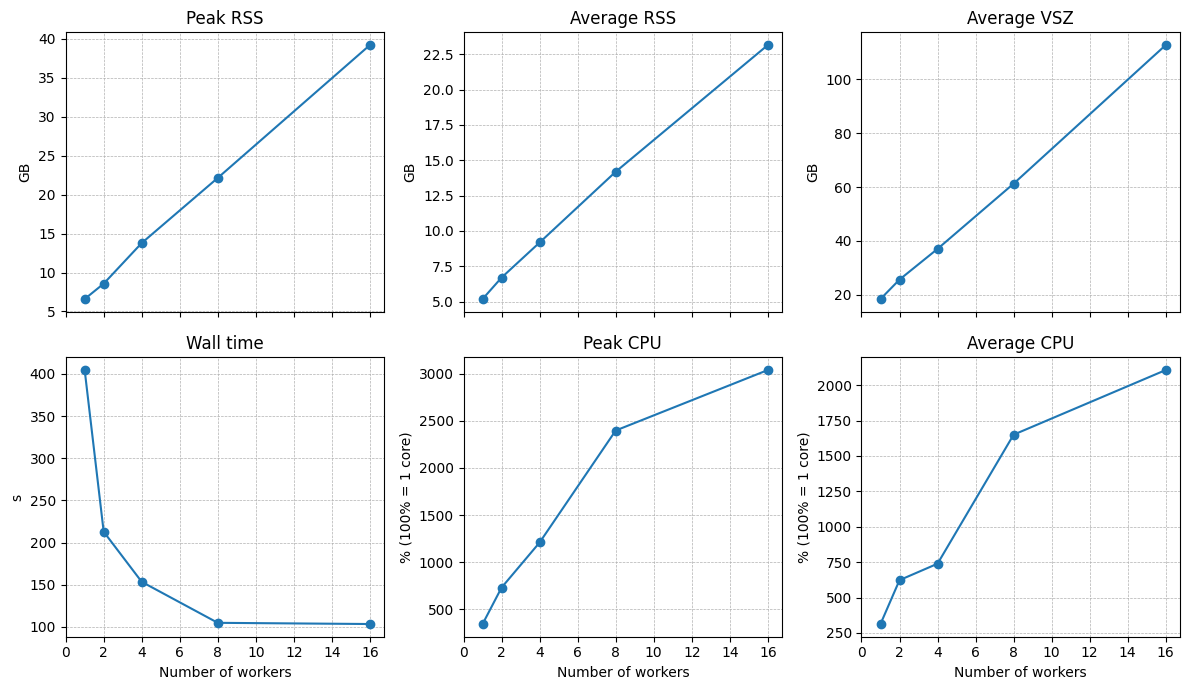

In [5]:
from IPython.display import Image, display

display(Image(filename="../figures/output_aggregate_mean.png"))

# Benchmark generation of single-cell representations from highly multiplexed images:

In [ ]:
import os

from dask.distributed import Client, LocalCluster

from tempfile import tempdir

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="48GB",
)

client = Client(cluster)

img_layer = "image_tiled"
labels_layer = "labels_cells_harpy"

instances_ids, instanes=hp.tb.extract_instances(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    depth = 100,
    diameter = 50,
    batch_size=500,
    zarr_output_path=os.path.join( tempdir, "zarr_folder" ),
    overwrite=True,
)

We varied the number of workers and obtained the following figures.

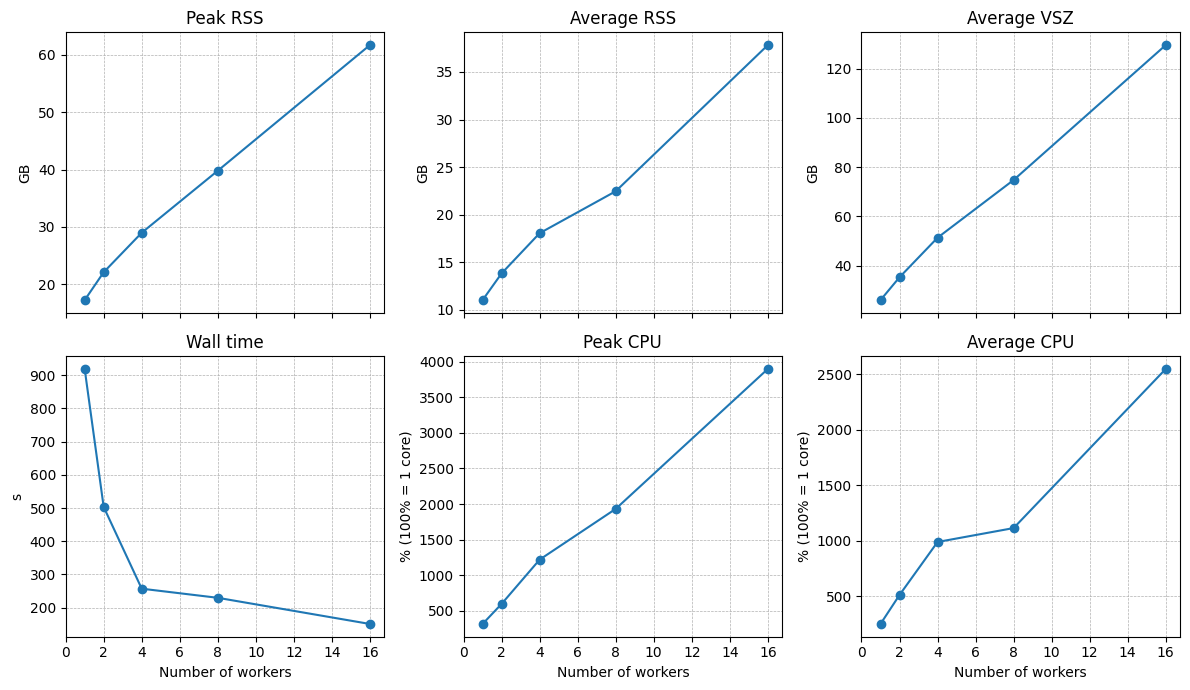

In [8]:
from IPython.display import Image, display

display(Image(filename="../figures/extract_instances.png"))